# Transfer learning

In [1]:
# https://www.youtube.com/watch?v=qaDe0qQZ5AQ
# Imports
import torch
import torchvision
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters
from torch.utils.data import (
    DataLoader,
)  # Gives easier dataset managment and creates mini batches
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import matplotlib.pyplot as plt
torch.manual_seed(42)#You can use torch.manual_seed function to seed the script globally
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from skimage import io
import os
from torch.utils.data import Dataset

In [2]:
'''Hyperparameters'''
num_classes = 3
learning_rate = 1e-4
batch_size = 100
num_epochs = 200
test_size = 0.25

# two writers for different colour
# 如果重新写入数据的话，就要关闭tensorboard然后重新运行下列writter代码
writer = SummaryWriter('runs/alexnet_10&fc')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# real data path
path_merged = r'C:\Users\SmartLab\Desktop\traditional recon and CAM\3d_Recon\6_Dataset\_Data for model\3_augted&Normalised'
# # less image for quick train test
# path_merged = r'C:\Users\SmartLab\Desktop\NUS\3d_Recon\6_Dataset\_Data for model\4_smallDataset'

In [3]:

# Designed for equal portion split  
class WallDefects(Dataset): #inherit from Dataset
    def __init__(self, root_dir, data, label, transform=None):
        self.transform = transform
        self.root_dir = root_dir
        self.data = data
        self.label = label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.data[index])
        image = io.imread(img_path)
        y_label = torch.tensor(self.label[index])

        if self.transform:
            image = self.transform(image)

        return (image, y_label)
    
    
    
# or you want equal portion for each classes
# using tensorflow train_test_split, stratify=y for equal portion split based on label
# https://discuss.pytorch.org/t/how-to-split-test-and-train-data-keeping-equal-proportions-of-each-class/21063/5
X = np.array([f for f in os.listdir(path_merged) if not f.startswith('.')])
y = np.array([filename[0] for filename in X]).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=0)

train_set = WallDefects(path_merged, data=X_train, label=y_train, transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)

test_set = WallDefects(path_merged, data=X_test, label=y_test,transform=transforms.ToTensor())
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

In [4]:
len(X),len(X_train),len(X_test)

(5926, 4444, 1482)

target label: 1


(<matplotlib.image.AxesImage at 0x1f712986250>, None)

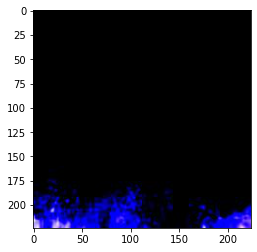

In [5]:
# 0_non: 2000
# 1_bigrowth:657 * 3 = 1971
# 2_crack: 1955
# total images = 2000+1971+1955=5926

def showImage(index, dataset):
    return plt.imshow(dataset[index][0].permute(1, 2, 0)),print(f'target label: {dataset[index][1]}')
showImage(-1, train_set) 

In [6]:

'''Load pretrained model'''
# Load pretrain model 
model = torchvision.models.alexnet(pretrained=True)
# If you want to do finetuning then set requires_grad = False
# Remove these two lines if you want to train entire model,
# and only want to load the pretrain weights.
for param in model.parameters():
    param.requires_grad = False

# set last layer trainable for to evalate the localisation capability since fc does not do localisation
for param in model.features[10:].parameters():
    param.requires_grad = True

'''Modify the fully connected layer of the model'''
# modify the last fully connected layer to simple layer, because we wanna train lasy conv layer 
# which should be trained to do classificaiton and localisation both well
model.classifier = nn.Sequential(
    nn.Linear(9216, num_classes)
)


# # how about freeze the fc as well, try if layer4 can do better localsation, since all classificaiton and
# # localisation work is done by layer 4
# for param in model.fc.parameters():
#     param.requires_grad = False



model.to(device)
print(model)


# complicate fc in the first experiment
# model.fc = nn.Sequential(
#     nn.Linear(2048, 1000), nn.ReLU(), 
#     nn.Linear(1000, 500), nn.ReLU(), 
#     nn.Linear(500, 200), nn.ReLU(), 
#     nn.Linear(200, num_classes)
# )

C:\Users\SmartLab\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\SmartLab\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=3, bias=True)
  )
)


In [7]:
# https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6
# check which layer requires grad
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)
        
        
# how about fixing FC layers? 
# so all the learning happens in the last convlayer, is it even better for localisation?

features.10.weight
features.10.bias
classifier.0.weight
classifier.0.bias


In [8]:
'''Training and check the cost'''
# difference btw ce and bce, here we use ce as later data size all based on it
# https://discuss.pytorch.org/t/can-i-use-cross-entropy-loss-as-a-binary-loss/39314/2
# Loss
criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss() #binary cross entrpy


# pytorch optimizer explicitly accepts parameter that requires grad
# We haven’t done yet as even the required grad is set to False, we still can update the weights
# So we should filter the parameters to only those requires_grad ones by using this code
# https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6
# optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, momentum=0.9)



lowest_loss = 9999
# Train Network
for epoch in range(num_epochs):
    
    '''training loss and accuracy cals'''
    losses = []
    num_correct = 0
    num_samples = 0
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.type(torch.LongTensor)
        targets = targets.to(device=device)
        # forward
        scores = model(data)
        loss = criterion(scores, targets)
        losses.append(loss)
        # backward
        optimizer.zero_grad()
        loss.backward()
        # gradient descent or adam step
        optimizer.step()
        # for accuracy cals
        _, predictions = scores.max(1)
        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)


    # tensorboard
    # 因为存储的文件有很多不规则名字（例如_）所以直接用 tensorboard --logdir=runs 是找不到的，所以
    # 需要用他之前规则的路径，然后tensorboard会在这个大路径里面搜寻文件，例如下面这个就是规则大路径
    # runs文件和这个python文件在一起，但是不能用这个路径因为有不规则符号
    # terminal: tensorboard --logdir /Users/t.wang/Desktop/NUS/References
    writer.add_scalar("Loss/ ->Train", sum(losses)/len(losses), epoch)
    print(f"Epoch {epoch+1} / {num_epochs} is {sum(losses)/len(losses):.5f} -> Training cost")
    
    # tensorboard
    # terminal: tensorboard --logdir=runs
    accuracy = round(float(num_correct)/float(num_samples)*100,2)
    writer.add_scalar(f"Accuracy/ ->Training", accuracy, epoch)    
    print(
        f"Got {num_correct} correct / {num_samples} in total with accuracy {accuracy}% -> Training accuracy"
    )
    
    
    
    '''test loss and accuracy cals'''
    model.eval() #no model tuning, just for test checking
    losses = []
    num_correct = 0
    num_samples = 0
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(test_loader):
            # Get data to cuda if possible
            data = data.to(device=device)
            targets = targets.type(torch.LongTensor)
            targets = targets.to(device=device)
            # forward
            scores = model(data)
            loss = criterion(scores, targets)
            losses.append(loss)
            # for accuracy cals
            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
    # Loss
    current_loss = sum(losses)/len(losses)
    writer.add_scalar("Loss/ ->Test", current_loss, epoch)
    print(f"Epoch {epoch+1} / {num_epochs} is {current_loss:.5f} -> Testing cost") 
    
    # Accuracy
    accuracy = round(float(num_correct)/float(num_samples)*100,2)
    writer.add_scalar(f"Accuracy/ ->Testing", accuracy, epoch)    
    print(
        f"Got {num_correct} correct / {num_samples} in total with accuracy {accuracy}% -> Testing accuracy"
    )

    
    # store the best model in terms of the loss
    if current_loss < lowest_loss:
        num = epoch+1
        best_model = model
        lowest_loss = current_loss
        highest_acc = accuracy
    print(f'the current best model is from epoch {num}')  
    print("==============================================================================")
    # Call flush() method to make sure that all pending events have been written to disk.  
    writer.flush()
    model.train() # back to model tuning again
    
    
# save the best model
print(f'saving the best model at {num}th epoch...')
torch.save(best_model.state_dict(), f'{num}th epoch_alexnet_10&fc_Testingloss={lowest_loss:.5f} and acc={highest_acc}%.pth')        
print('Job Done!!!!!')

# 大概5h算10epoch，半小时1个epoch

Epoch 1 / 200 is 0.78261 -> Training cost
Got 2939 correct / 4444 in total with accuracy 66.13% -> Training accuracy
Epoch 1 / 200 is 0.50458 -> Testing cost
Got 1243 correct / 1482 in total with accuracy 83.87% -> Testing accuracy
the current best model is from epoch 1
Epoch 2 / 200 is 0.44782 -> Training cost
Got 3784 correct / 4444 in total with accuracy 85.15% -> Training accuracy
Epoch 2 / 200 is 0.41093 -> Testing cost
Got 1283 correct / 1482 in total with accuracy 86.57% -> Testing accuracy
the current best model is from epoch 2
Epoch 3 / 200 is 0.39292 -> Training cost
Got 3851 correct / 4444 in total with accuracy 86.66% -> Training accuracy
Epoch 3 / 200 is 0.37313 -> Testing cost
Got 1297 correct / 1482 in total with accuracy 87.52% -> Testing accuracy
the current best model is from epoch 3
Epoch 4 / 200 is 0.36039 -> Training cost
Got 3905 correct / 4444 in total with accuracy 87.87% -> Training accuracy
Epoch 4 / 200 is 0.35039 -> Testing cost
Got 1310 correct / 1482 in to

Epoch 24 / 200 is 0.24755 -> Testing cost
Got 1349 correct / 1482 in total with accuracy 91.03% -> Testing accuracy
the current best model is from epoch 24
Epoch 25 / 200 is 0.22225 -> Training cost
Got 4103 correct / 4444 in total with accuracy 92.33% -> Training accuracy
Epoch 25 / 200 is 0.24666 -> Testing cost
Got 1354 correct / 1482 in total with accuracy 91.36% -> Testing accuracy
the current best model is from epoch 25
Epoch 26 / 200 is 0.22093 -> Training cost
Got 4104 correct / 4444 in total with accuracy 92.35% -> Training accuracy
Epoch 26 / 200 is 0.24370 -> Testing cost
Got 1347 correct / 1482 in total with accuracy 90.89% -> Testing accuracy
the current best model is from epoch 26
Epoch 27 / 200 is 0.21771 -> Training cost
Got 4105 correct / 4444 in total with accuracy 92.37% -> Training accuracy
Epoch 27 / 200 is 0.24327 -> Testing cost
Got 1351 correct / 1482 in total with accuracy 91.16% -> Testing accuracy
the current best model is from epoch 27
Epoch 28 / 200 is 0.21

Epoch 48 / 200 is 0.18049 -> Training cost
Got 4169 correct / 4444 in total with accuracy 93.81% -> Training accuracy
Epoch 48 / 200 is 0.22598 -> Testing cost
Got 1356 correct / 1482 in total with accuracy 91.5% -> Testing accuracy
the current best model is from epoch 47
Epoch 49 / 200 is 0.18052 -> Training cost
Got 4178 correct / 4444 in total with accuracy 94.01% -> Training accuracy
Epoch 49 / 200 is 0.22469 -> Testing cost
Got 1354 correct / 1482 in total with accuracy 91.36% -> Testing accuracy
the current best model is from epoch 49
Epoch 50 / 200 is 0.17894 -> Training cost
Got 4173 correct / 4444 in total with accuracy 93.9% -> Training accuracy
Epoch 50 / 200 is 0.22404 -> Testing cost
Got 1357 correct / 1482 in total with accuracy 91.57% -> Testing accuracy
the current best model is from epoch 50
Epoch 51 / 200 is 0.17806 -> Training cost
Got 4183 correct / 4444 in total with accuracy 94.13% -> Training accuracy
Epoch 51 / 200 is 0.22498 -> Testing cost
Got 1359 correct / 1

Epoch 71 / 200 is 0.21426 -> Testing cost
Got 1359 correct / 1482 in total with accuracy 91.7% -> Testing accuracy
the current best model is from epoch 71
Epoch 72 / 200 is 0.15691 -> Training cost
Got 4217 correct / 4444 in total with accuracy 94.89% -> Training accuracy
Epoch 72 / 200 is 0.21393 -> Testing cost
Got 1358 correct / 1482 in total with accuracy 91.63% -> Testing accuracy
the current best model is from epoch 72
Epoch 73 / 200 is 0.15644 -> Training cost
Got 4212 correct / 4444 in total with accuracy 94.78% -> Training accuracy
Epoch 73 / 200 is 0.21474 -> Testing cost
Got 1358 correct / 1482 in total with accuracy 91.63% -> Testing accuracy
the current best model is from epoch 72
Epoch 74 / 200 is 0.15454 -> Training cost
Got 4221 correct / 4444 in total with accuracy 94.98% -> Training accuracy
Epoch 74 / 200 is 0.21360 -> Testing cost
Got 1358 correct / 1482 in total with accuracy 91.63% -> Testing accuracy
the current best model is from epoch 74
Epoch 75 / 200 is 0.154

Epoch 95 / 200 is 0.13976 -> Training cost
Got 4247 correct / 4444 in total with accuracy 95.57% -> Training accuracy
Epoch 95 / 200 is 0.20761 -> Testing cost
Got 1363 correct / 1482 in total with accuracy 91.97% -> Testing accuracy
the current best model is from epoch 95
Epoch 96 / 200 is 0.13967 -> Training cost
Got 4248 correct / 4444 in total with accuracy 95.59% -> Training accuracy
Epoch 96 / 200 is 0.20997 -> Testing cost
Got 1368 correct / 1482 in total with accuracy 92.31% -> Testing accuracy
the current best model is from epoch 95
Epoch 97 / 200 is 0.13839 -> Training cost
Got 4246 correct / 4444 in total with accuracy 95.54% -> Training accuracy
Epoch 97 / 200 is 0.20874 -> Testing cost
Got 1362 correct / 1482 in total with accuracy 91.9% -> Testing accuracy
the current best model is from epoch 95
Epoch 98 / 200 is 0.13844 -> Training cost
Got 4249 correct / 4444 in total with accuracy 95.61% -> Training accuracy
Epoch 98 / 200 is 0.20929 -> Testing cost
Got 1364 correct / 

Epoch 118 / 200 is 0.20404 -> Testing cost
Got 1368 correct / 1482 in total with accuracy 92.31% -> Testing accuracy
the current best model is from epoch 118
Epoch 119 / 200 is 0.12768 -> Training cost
Got 4275 correct / 4444 in total with accuracy 96.2% -> Training accuracy
Epoch 119 / 200 is 0.20445 -> Testing cost
Got 1367 correct / 1482 in total with accuracy 92.24% -> Testing accuracy
the current best model is from epoch 118
Epoch 120 / 200 is 0.12594 -> Training cost
Got 4271 correct / 4444 in total with accuracy 96.11% -> Training accuracy
Epoch 120 / 200 is 0.20355 -> Testing cost
Got 1370 correct / 1482 in total with accuracy 92.44% -> Testing accuracy
the current best model is from epoch 120
Epoch 121 / 200 is 0.12632 -> Training cost
Got 4271 correct / 4444 in total with accuracy 96.11% -> Training accuracy
Epoch 121 / 200 is 0.20495 -> Testing cost
Got 1369 correct / 1482 in total with accuracy 92.38% -> Testing accuracy
the current best model is from epoch 120
Epoch 122 / 

Epoch 142 / 200 is 0.11685 -> Training cost
Got 4283 correct / 4444 in total with accuracy 96.38% -> Training accuracy
Epoch 142 / 200 is 0.20222 -> Testing cost
Got 1372 correct / 1482 in total with accuracy 92.58% -> Testing accuracy
the current best model is from epoch 139
Epoch 143 / 200 is 0.11688 -> Training cost
Got 4283 correct / 4444 in total with accuracy 96.38% -> Training accuracy
Epoch 143 / 200 is 0.20150 -> Testing cost
Got 1371 correct / 1482 in total with accuracy 92.51% -> Testing accuracy
the current best model is from epoch 139
Epoch 144 / 200 is 0.11688 -> Training cost
Got 4281 correct / 4444 in total with accuracy 96.33% -> Training accuracy
Epoch 144 / 200 is 0.20097 -> Testing cost
Got 1372 correct / 1482 in total with accuracy 92.58% -> Testing accuracy
the current best model is from epoch 144
Epoch 145 / 200 is 0.11556 -> Training cost
Got 4289 correct / 4444 in total with accuracy 96.51% -> Training accuracy
Epoch 145 / 200 is 0.20276 -> Testing cost
Got 137

Epoch 165 / 200 is 0.19932 -> Testing cost
Got 1374 correct / 1482 in total with accuracy 92.71% -> Testing accuracy
the current best model is from epoch 165
Epoch 166 / 200 is 0.10791 -> Training cost
Got 4298 correct / 4444 in total with accuracy 96.71% -> Training accuracy
Epoch 166 / 200 is 0.20093 -> Testing cost
Got 1374 correct / 1482 in total with accuracy 92.71% -> Testing accuracy
the current best model is from epoch 165
Epoch 167 / 200 is 0.10891 -> Training cost
Got 4297 correct / 4444 in total with accuracy 96.69% -> Training accuracy
Epoch 167 / 200 is 0.20072 -> Testing cost
Got 1376 correct / 1482 in total with accuracy 92.85% -> Testing accuracy
the current best model is from epoch 165
Epoch 168 / 200 is 0.10791 -> Training cost
Got 4299 correct / 4444 in total with accuracy 96.74% -> Training accuracy
Epoch 168 / 200 is 0.19884 -> Testing cost
Got 1373 correct / 1482 in total with accuracy 92.65% -> Testing accuracy
the current best model is from epoch 168
Epoch 169 /

Epoch 189 / 200 is 0.10119 -> Training cost
Got 4313 correct / 4444 in total with accuracy 97.05% -> Training accuracy
Epoch 189 / 200 is 0.19889 -> Testing cost
Got 1376 correct / 1482 in total with accuracy 92.85% -> Testing accuracy
the current best model is from epoch 181
Epoch 190 / 200 is 0.10245 -> Training cost
Got 4310 correct / 4444 in total with accuracy 96.98% -> Training accuracy
Epoch 190 / 200 is 0.19769 -> Testing cost
Got 1374 correct / 1482 in total with accuracy 92.71% -> Testing accuracy
the current best model is from epoch 190
Epoch 191 / 200 is 0.10205 -> Training cost
Got 4310 correct / 4444 in total with accuracy 96.98% -> Training accuracy
Epoch 191 / 200 is 0.19892 -> Testing cost
Got 1373 correct / 1482 in total with accuracy 92.65% -> Testing accuracy
the current best model is from epoch 190
Epoch 192 / 200 is 0.10319 -> Training cost
Got 4310 correct / 4444 in total with accuracy 96.98% -> Training accuracy
Epoch 192 / 200 is 0.19889 -> Testing cost
Got 137